In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon May 20 17:32:00 2019

@author: Administrator
"""

import numpy as np
import pandas as pd
import lightgbm as lgb
import os

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
import json 
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from itertools import product
import ast
import math
from sklearn.cluster import KMeans
import time
from datetime import datetime

In [2]:


######################################## 基本数据集加载  ########################################
data_path = './processed/'
print('基本数据集加载')
data = pd.read_csv(data_path + 'data_guangzhou.csv',parse_dates=['req_time','plan_time'])
profiles = pd.read_csv('../data/data_set_phase2/profiles.csv') 
print('完成加载')

########################################## 特征工程  ###########################################
print('特征工程')
########################################  经纬度特征  ##########################################
print('经纬度特征')
#1、曼哈顿距离特征：两点投影到各轴上的距离总和
data['o_lng'] = data['o'].apply(lambda x: float(x.split(',')[0]))
data['o_lat'] = data['o'].apply(lambda x: float(x.split(',')[1]))
data['d_lng'] = data['d'].apply(lambda x: float(x.split(',')[0]))
data['d_lat'] = data['d'].apply(lambda x: float(x.split(',')[1])) 
data['od_manhattan_distance'] = abs(data['o_lng']-data['d_lng'])+abs(data['o_lat']-data['d_lat'])

#2、直线距离特征：根据经纬度坐标计算两点间的直线距离
def GetDistance(lng1, lat1, lng2, lat2):
    #地球赤道半径6378.137km
    EARTH_RADIUS = 6378.137
    #把经纬度转换成度（°）
    lng1 = lng1 * (math.pi / 180.0)
    lng2 = lng2 * (math.pi / 180.0)
    lat1 = lat1 * (math.pi / 180.0)
    lat2 = lat2 * (math.pi / 180.0)

    dis1 = lat1 - lat2
    dis2 = lng1 - lng2
    #以1m为球的半径，求球上两点的距离
    s = 2 * math.asin(
        ((math.sin(dis1 / 2)) ** 2 + math.cos(lat1) * math.cos(lat2) * (math.sin(dis2 / 2)) ** 2) ** 0.5)
    #换算成地球的半径：6378.137km *1000 = 6378137m
    s = s * EARTH_RADIUS * 1000
    return s
data['od_manhattan_distance_detail']=data.apply(lambda row:GetDistance(row['o_lng'],row['o_lat'],row['d_lng'],row['d_lat']),axis=1)


#3、始终点的经纬度分别与始终点的经纬度的平均值和众数的差之和
o_co = data[['o']]
d_co = data[['d']]

o_co.columns = ['co']
d_co.columns = ['co']

all_co = pd.concat([d_co, o_co]).drop_duplicates()
all_co['lng'] = all_co['co'].apply(lambda x: float(x.split(',')[0]))
all_co['lat'] = all_co['co'].apply(lambda x: float(x.split(',')[1]))
lng_mean = all_co['lng'].mean()
lat_mean = all_co['lat'].mean()

lng_mode = all_co['lng'].mode()[0]
lat_mode = all_co['lat'].mode()[0]
data['o_main_centroid_mean_dis'] = abs(
    data['o_lng']-lng_mean)+abs(data['o_lat']-lat_mean)
data['d_main_centroid_mean_dis'] = abs(
    data['d_lng']-lng_mean)+abs(data['d_lat']-lat_mean)

data['o_main_centroid_mode_dis'] = abs(
    data['o_lng']-lng_mode)+abs(data['o_lat']-lat_mode)
data['d_main_centroid_mode_dis'] = abs(
    data['d_lng']-lng_mode)+abs(data['d_lat']-lat_mode)

#4、所有地点的经纬度聚类
data['o_cluster', 'd_cluster'] = np.nan
clf_KMeans = KMeans(n_clusters=11)#构造聚类器
cluster = clf_KMeans.fit_predict(all_co[['lng','lat']])#聚类
index = 0
for co in tqdm(all_co['co']):
    #所有地点的经纬度聚类
    data.loc[(data['o'] == co), 'o_cluster'] = cluster[index]
    data.loc[(data['d'] == co), 'd_cluster'] = cluster[index]
    index +=1

od_feature = ['od_manhattan_distance', 'od_manhattan_distance_detail', 'o_main_centroid_mean_dis', 'd_main_centroid_mean_dis', 'o_main_centroid_mode_dis', 'd_main_centroid_mode_dis', 'o_cluster', 'd_cluster']
print('经纬度特征数量：', len(od_feature), od_feature) 

基本数据集加载
完成加载
特征工程
经纬度特征


100%|██████████████████████████████████████████████████████████████████████████████| 3702/3702 [06:36<00:00, 14.68it/s]


经纬度特征数量： 8 ['od_manhattan_distance', 'od_manhattan_distance_detail', 'o_main_centroid_mean_dis', 'd_main_centroid_mean_dis', 'o_main_centroid_mode_dis', 'd_main_centroid_mode_dis', 'o_cluster', 'd_cluster']


In [3]:
########################################  距离特征  ##########################################
print('距离特征')
def minkowski_distance(x1, x2, y1, y2, p):
    return ((abs(x2 - x1) ** p) + (abs(y2 - y1)) ** p) ** (1.0 / p)    

def calculate_direction(d_lon, d_lat):  
    result = np.zeros(len(d_lon))   
    l = np.sqrt(d_lon**2 + d_lat**2)
    result[d_lon>0] = (180/np.pi)*np.arcsin(d_lat[d_lon>0]/l[d_lon>0])
    idx = (d_lon<0) & (d_lat>0)
    result[idx] = 180 - (180/np.pi)*np.arcsin(d_lat[idx]/l[idx])
    idx = (d_lon<0) & (d_lat<0)
    result[idx] = -180 - (180/np.pi)*np.arcsin(d_lat[idx]/l[idx])   
    return result

def add_travel_vector_features(df):    
    df['delta_longitude'] = df.o_lng - df.d_lng
    df['delta_latitude'] = df.o_lat - df.d_lat   
    df['pickup_x'] = np.cos(df.o_lat) * np.cos(df.o_lng)
    df['pickup_y'] = np.cos(df.o_lat) * np.sin(df.o_lng)
    df['pickup_z'] = np.sin(df.o_lat)   
    df['dropoff_x'] = np.cos(df.d_lat) * np.cos(df.d_lng)
    df['dropoff_y'] = np.cos(df.d_lat) * np.sin(df.d_lng)
    df['dropoff_z'] = np.sin(df.d_lat)

data['manhattan'] = minkowski_distance(data.o_lng, data.d_lng, 
                                           data.o_lat, data.d_lat, 1)
data['euclidean']=minkowski_distance(data.o_lng, data.d_lng, 
                                           data.o_lat, data.d_lat, 2)

add_travel_vector_features(data)
data['direction'] = calculate_direction(data.delta_longitude, data.delta_latitude)

distance_feature = ['manhattan','euclidean','delta_longitude','delta_latitude','pickup_x','pickup_y','pickup_z','dropoff_x','dropoff_y','dropoff_z','direction']
print('距离特征数量：', len(distance_feature), distance_feature) 

################################  plan_time & req_time特征  ###################################
print('plan_time & req_time特征') 
#1、原始时间特征上的处理
data['req_time_hour'] = data['req_time'].dt.hour
data['req_time_weekday'] = data['req_time'].dt.weekday
data['req_time_minute'] = data['req_time'].dt.minute
data['req_time_date_d'] = data['req_time'].dt.strftime('%d').astype(int)

    
#2、时差特征
data['time_diff'] = (data['plan_time']- data['req_time']).dt.seconds

#3、请求的时间点与当天早上6点、中午12点、下午6点、晚上6点的分钟差距
def diff_6_clock(time_point):
    six_clock=str(time_point.year)+'-'+str(time_point.month)+'-'+str(time_point.day)+' '+str(6)+':0:00'
    six_clock=pd.to_datetime(six_clock)
    the_diff=(six_clock- time_point).total_seconds()
    return abs(the_diff/60)

def diff_12_clock(time_point):
    t12_clock=str(time_point.year)+'-'+str(time_point.month)+'-'+str(time_point.day)+' '+str(12)+':0:00'
    t12_clock=pd.to_datetime(t12_clock)
    the_diff=(t12_clock- time_point).total_seconds()
    return abs(the_diff/60)

def diff_18_clock(time_point):
    t18_clock=str(time_point.year)+'-'+str(time_point.month)+'-'+str(time_point.day)+' '+str(18)+':0:00'
    t18_clock=pd.to_datetime(t18_clock)
    the_diff=(t18_clock- time_point).total_seconds()
    return abs(the_diff/60)

def diff_24_clock(time_point):
    t24_clock=str(time_point.year)+'-'+str(time_point.month)+'-'+str(time_point.day)+' '+str(23)+':59:00'
    t24_clock=pd.to_datetime(t24_clock)
    the_diff=(t24_clock- time_point).total_seconds()
    return abs(the_diff/60)

data['diff_6_cloc']=data['req_time'].apply(diff_6_clock)
data['diff_12_clock']=data['req_time'].apply(diff_12_clock)
data['diff_18_clock']=data['req_time'].apply(diff_18_clock)
data['diff_24_clock']=data['req_time'].apply(diff_24_clock)

time_feature = ['req_time_hour', 'req_time_weekday', 'req_time_minute', 'req_time_date_d', 'time_diff', 
                'diff_6_cloc', 'diff_12_clock', 'diff_18_clock', 'diff_24_clock']
print('plan_time & req_time特征数量：', len(time_feature),time_feature)

################################  对profile的降维提取特征  ###################################
print('对profile的降维提取特征') 
x = profiles.drop(['pid'], axis=1).values
svd = TruncatedSVD(n_components=10, n_iter=20, random_state=2019)
svd_x = svd.fit_transform(x)
svd_feas = pd.DataFrame(svd_x)
svd_feas.columns = ['svd_fea_{}'.format(i) for i in range(10)]
svd_feas['pid'] = profiles['pid'].values
data = data.merge(svd_feas, on='pid', how='left')

profiles_svd_feature = ['svd_fea_{}'.format(i) for i in range(10)]
print('对profile的降维提取特征完成数量：', len(profiles_svd_feature), profiles_svd_feature) 

##############################  plans百度地图推荐交通方式特征  #################################
# ### plans百度地图推荐特征
#    
#      此处特征包括：
#      *Plans中针对这次导航任务，百度地图所提供的路线选择:12
#      *提供的路线选择中距离、价格和所花时间的最大值、最小值、均值、方差:12
#      *提供的路线选择中距离最大和最小、价格最高和最低、所花时间最多和最少的交通方式:6
#      *提供的路线选择中的第一种交通方式:1
#      *模式数据压缩:10
print('plans百度地图推荐交通方式特征') 
data['plans_json'] = data['plans'].fillna('[]').apply(lambda x: json.loads(x))
def gen_plan_feas(data):
    n                                           = data.shape[0]
    mode_list_feas                              = np.zeros((n, 12))
    max_dist, min_dist, mean_dist, std_dist     = np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))

    max_price, min_price, mean_price, std_price = np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))

    max_eta, min_eta, mean_eta, std_eta         = np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))

    min_dist_mode, max_dist_mode, min_price_mode, max_price_mode, min_eta_mode, max_eta_mode, first_mode =     np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))
  
    mode_texts = []
    for i, plan in tqdm(enumerate(data['plans_json'].values)):
        if len(plan) == 0:
            cur_plan_list   = []
        else:
            cur_plan_list   = plan
        if len(cur_plan_list) == 0:
            mode_list_feas[i, 0] =  1
            first_mode[i]        =  0
            max_dist[i]          = -1
            min_dist[i]          = -1
            mean_dist[i]         = -1
            std_dist[i]          = -1
            max_price[i]         = -1
            min_price[i]         = -1
            mean_price[i]        = -1
            std_price[i]         = -1
            max_eta[i]           = -1
            min_eta[i]           = -1
            mean_eta[i]          = -1
            std_eta[i]           = -1
            min_dist_mode[i]     = -1
            max_dist_mode[i]     = -1
            min_price_mode[i]    = -1
            max_price_mode[i]    = -1
            min_eta_mode[i]      = -1
            max_eta_mode[i]      = -1
            mode_texts.append('word_null')
        else:
            distance_list = []
            price_list = []
            eta_list = []
            mode_list = []
            for tmp_dit in cur_plan_list:
                distance_list.append(int(tmp_dit['distance']))
                if tmp_dit['price'] == '':
                    price_list.append(0)
                else:
                    price_list.append(int(tmp_dit['price']))
                eta_list.append(int(tmp_dit['eta']))
                mode_list.append(int(tmp_dit['transport_mode']))
            mode_texts.append(
                ' '.join(['word_{}'.format(mode) for mode in mode_list]))
            distance_list                = np.array(distance_list)
            price_list                   = np.array(price_list)
            eta_list                     = np.array(eta_list)
            mode_list                    = np.array(mode_list, dtype='int')
            mode_list_feas[i, mode_list] = 1
            distance_sort_idx            = np.argsort(distance_list)
            price_sort_idx               = np.argsort(price_list)
            eta_sort_idx                 = np.argsort(eta_list)
            max_dist[i]                  = distance_list[distance_sort_idx[-1]]
            min_dist[i]                  = distance_list[distance_sort_idx[0]]
            mean_dist[i]                 = np.mean(distance_list)
            std_dist[i]                  = np.std(distance_list)
            max_price[i]                 = price_list[price_sort_idx[-1]]
            min_price[i]                 = price_list[price_sort_idx[0]]
            mean_price[i]                = np.mean(price_list)
            std_price[i]                 = np.std(price_list)
            max_eta[i]                   = eta_list[eta_sort_idx[-1]]
            min_eta[i]                   = eta_list[eta_sort_idx[0]]
            mean_eta[i]                  = np.mean(eta_list)
            std_eta[i]                   = np.std(eta_list)
            first_mode[i]                = mode_list[0]
            max_dist_mode[i]             = mode_list[distance_sort_idx[-1]]
            min_dist_mode[i]             = mode_list[distance_sort_idx[0]]
            max_price_mode[i]            = mode_list[price_sort_idx[-1]]
            min_price_mode[i]            = mode_list[price_sort_idx[0]]
            max_eta_mode[i]              = mode_list[eta_sort_idx[-1]]
            min_eta_mode[i]              = mode_list[eta_sort_idx[0]]
    feature_data                   =  pd.DataFrame(mode_list_feas)
    feature_data.columns           =  ['mode_feas_{}'.format(i) for i in range(12)]
    feature_data['max_dist']       =  max_dist
    feature_data['min_dist']       =  min_dist
    feature_data['mean_dist']      =  mean_dist
    feature_data['std_dist']       =  std_dist
    feature_data['max_price']      = max_price
    feature_data['min_price']      = min_price
    feature_data['mean_price']     = mean_price
    feature_data['std_price']      = std_price
    feature_data['max_eta']        = max_eta
    feature_data['min_eta']        = min_eta
    feature_data['mean_eta']       = mean_eta
    feature_data['std_eta']        = std_eta
    feature_data['max_dist_mode']  = max_dist_mode
    feature_data['min_dist_mode']  = min_dist_mode
    feature_data['max_price_mode'] = max_price_mode
    feature_data['min_price_mode'] = min_price_mode
    feature_data['max_eta_mode']   = max_eta_mode
    feature_data['min_eta_mode']   = min_eta_mode
    feature_data['first_mode']     = first_mode
    print('mode tfidf...')
    tfidf_enc = TfidfVectorizer(ngram_range=(1, 2))
    tfidf_vec = tfidf_enc.fit_transform(mode_texts)
    svd_enc = TruncatedSVD(n_components=10, n_iter=20, random_state=2019)
    mode_svd = svd_enc.fit_transform(tfidf_vec)
    mode_svd = pd.DataFrame(mode_svd)
    mode_svd.columns = ['svd_mode_{}'.format(i) for i in range(10)]
    plan_fea = pd.concat([feature_data, mode_svd], axis=1)
    plan_fea['sid'] = data['sid'].values
    return plan_fea

data_plans = gen_plan_feas(data)
data = data.merge(data_plans, on='sid', how='left')

plan_feature = ['mode_feas_0', 'mode_feas_1', 'mode_feas_2', 'mode_feas_3', 'mode_feas_4', 'mode_feas_5', 'mode_feas_6', 'mode_feas_7', 'mode_feas_8', 'mode_feas_9', 'mode_feas_10', 'mode_feas_11', 
               'max_dist', 'min_dist', 'mean_dist', 'std_dist', 'max_price', 'min_price', 'mean_price', 'std_price', 'max_eta', 'min_eta', 'mean_eta', 'std_eta', 'max_dist_mode', 'min_dist_mode', 'max_price_mode', 'min_price_mode', 'max_eta_mode', 'min_eta_mode', 
               'first_mode', 'svd_mode_0', 'svd_mode_1', 'svd_mode_2', 'svd_mode_3', 'svd_mode_4', 'svd_mode_5', 'svd_mode_6', 'svd_mode_7', 'svd_mode_8', 'svd_mode_9']
print('plans百度地图推荐交通方式特征数量：', len(plan_feature), plan_feature) 


距离特征
距离特征数量： 11 ['manhattan', 'euclidean', 'delta_longitude', 'delta_latitude', 'pickup_x', 'pickup_y', 'pickup_z', 'dropoff_x', 'dropoff_y', 'dropoff_z', 'direction']
plan_time & req_time特征
plan_time & req_time特征数量： 9 ['req_time_hour', 'req_time_weekday', 'req_time_minute', 'req_time_date_d', 'time_diff', 'diff_6_cloc', 'diff_12_clock', 'diff_18_clock', 'diff_24_clock']
对profile的降维提取特征
对profile的降维提取特征完成数量： 10 ['svd_fea_0', 'svd_fea_1', 'svd_fea_2', 'svd_fea_3', 'svd_fea_4', 'svd_fea_5', 'svd_fea_6', 'svd_fea_7', 'svd_fea_8', 'svd_fea_9']
plans百度地图推荐交通方式特征


569040it [01:24, 6696.32it/s]


mode tfidf...
plans百度地图推荐交通方式特征数量： 41 ['mode_feas_0', 'mode_feas_1', 'mode_feas_2', 'mode_feas_3', 'mode_feas_4', 'mode_feas_5', 'mode_feas_6', 'mode_feas_7', 'mode_feas_8', 'mode_feas_9', 'mode_feas_10', 'mode_feas_11', 'max_dist', 'min_dist', 'mean_dist', 'std_dist', 'max_price', 'min_price', 'mean_price', 'std_price', 'max_eta', 'min_eta', 'mean_eta', 'std_eta', 'max_dist_mode', 'min_dist_mode', 'max_price_mode', 'min_price_mode', 'max_eta_mode', 'min_eta_mode', 'first_mode', 'svd_mode_0', 'svd_mode_1', 'svd_mode_2', 'svd_mode_3', 'svd_mode_4', 'svd_mode_5', 'svd_mode_6', 'svd_mode_7', 'svd_mode_8', 'svd_mode_9']


In [4]:
##############################  plan推荐mode平铺特征  #################################
print('plan推荐mode平铺特征')
#对plans内的信息直接进行平铺，平铺时求取每个mode的距离、price、eta，根据mode在plan中出现的次序给出排名信息。这样就构建了11*4个特征
data['plans_json'] = data['plans'].fillna('[]').apply(lambda x: json.loads(x))
def gen_plan_pingpu_feas(data):  
    #创建用于放置mode平均距离、平均价格、平均eta、出现位置排名,共11个模式的11*4个特征 （为0的模式就不做标识了） 添加model所属的工具模态
    n                                           = data.shape[0]
    #mode_list_feas                              = np.zeros((n, 12))
    model_1_dist,model_1_price,model_1_eta,model_1_rank  =   np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))
    model_2_dist,model_2_price,model_2_eta,model_2_rank  =   np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))
    model_3_dist,model_3_price,model_3_eta,model_3_rank  =   np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))
    model_4_dist,model_4_price,model_4_eta,model_4_rank  =   np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))
    model_5_dist,model_5_price,model_5_eta,model_5_rank  =   np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))
    model_6_dist,model_6_price,model_6_eta,model_6_rank  =   np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))
    model_7_dist,model_7_price,model_7_eta,model_7_rank  =   np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))
    model_8_dist,model_8_price,model_8_eta,model_8_rank  =   np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))
    model_9_dist,model_9_price,model_9_eta,model_9_rank  =   np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))
    model_10_dist,model_10_price,model_10_eta,model_10_rank  =   np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))
    model_11_dist,model_11_price,model_11_eta,model_11_rank  =   np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))

    n=0
    for i, plan in tqdm(enumerate(data['plans_json'].values)):
        if len(plan) == 0:
            cur_plan_list   = []
        else:
            cur_plan_list   = plan
        if len(cur_plan_list) == 0:
            model_1_dist[i]=-1
            model_1_price[i]=-1
            model_1_eta[i]=-1
            model_1_rank[i]=-1
            model_2_dist[i]=-1
            model_2_price[i]=-1
            model_2_eta[i]=-1
            model_2_rank[i]=-1
            model_3_dist[i]=-1
            model_3_price[i]=-1
            model_3_eta[i]=-1
            model_3_rank[i]=-1
            model_4_dist[i]=-1
            model_4_price[i]=-1
            model_4_eta[i]=-1
            model_4_rank[i]=-1
            model_5_dist[i]=-1
            model_5_price[i]=-1
            model_5_eta[i]=-1
            model_5_rank[i]=-1
            model_6_dist[i]=-1
            model_6_price[i]=-1
            model_6_eta[i]=-1
            model_6_rank[i]=-1
            model_7_dist[i]=-1
            model_7_price[i]=-1
            model_7_eta[i]=-1
            model_7_rank[i]=-1
            model_8_dist[i]=-1
            model_8_price[i]=-1
            model_8_eta[i]=-1
            model_8_rank[i]=-1
            model_9_dist[i]=-1
            model_9_price[i]=-1
            model_9_eta[i]=-1
            model_9_rank[i]=-1
            model_10_dist[i]=-1
            model_10_price[i]=-1
            model_10_eta[i]=-1
            model_10_rank[i]=-1
            model_11_dist[i]=-1
            model_11_price[i]=-1
            model_11_eta[i]=-1
            model_11_rank[i]=-1
        else:
            
            model_1_dist_list=[]
            model_1_price_list=[]
            model_1_eta_list=[]
            model_1_rank_list=[]
            model_2_dist_list=[]
            model_2_price_list=[]
            model_2_eta_list=[]
            model_2_rank_list=[]
            model_3_dist_list=[]
            model_3_price_list=[]
            model_3_eta_list=[]
            model_3_rank_list=[]
            model_4_dist_list=[]
            model_4_price_list=[]
            model_4_eta_list=[]
            model_4_rank_list=[]
            model_5_dist_list=[]
            model_5_price_list=[]
            model_5_eta_list=[]
            model_5_rank_list=[]
            model_6_dist_list=[]
            model_6_price_list=[]
            model_6_eta_list=[]
            model_6_rank_list=[]
            model_7_dist_list=[]
            model_7_price_list=[]
            model_7_eta_list=[]
            model_7_rank_list=[]
            model_8_dist_list=[]
            model_8_price_list=[]
            model_8_eta_list=[]
            model_8_rank_list=[]
            model_9_dist_list=[]
            model_9_price_list=[]
            model_9_eta_list=[]
            model_9_rank_list=[]
            model_10_dist_list=[]
            model_10_price_list=[]
            model_10_eta_list=[]
            model_10_rank_list=[]
            model_11_dist_list=[]
            model_11_price_list=[]
            model_11_eta_list=[]
            model_11_rank_list=[]

            mode_list = []
            for tmp_dit in cur_plan_list:
                if tmp_dit['price'] == '':
                    tmp_dit['price']=0
                if tmp_dit['transport_mode']==1:
                    model_1_dist_list.append(int(tmp_dit['distance']))
                    model_1_price_list.append(int(tmp_dit['price']))
                    model_1_eta_list.append(int(tmp_dit['eta']))
                elif tmp_dit['transport_mode']==2:
                    model_2_dist_list.append(int(tmp_dit['distance']))
                    model_2_price_list.append(int(tmp_dit['price']))
                    model_2_eta_list.append(int(tmp_dit['eta']))
                elif tmp_dit['transport_mode']==3:
                    model_3_dist_list.append(int(tmp_dit['distance']))
                    model_3_price_list.append(int(tmp_dit['price']))
                    model_3_eta_list.append(int(tmp_dit['eta']))
                elif tmp_dit['transport_mode']==4:
                    model_4_dist_list.append(int(tmp_dit['distance']))
                    model_4_price_list.append(int(tmp_dit['price']))
                    model_4_eta_list.append(int(tmp_dit['eta']))
                elif tmp_dit['transport_mode']==5:
                    model_5_dist_list.append(int(tmp_dit['distance']))
                    model_5_price_list.append(int(tmp_dit['price']))
                    model_5_eta_list.append(int(tmp_dit['eta']))
                elif tmp_dit['transport_mode']==6:
                    model_6_dist_list.append(int(tmp_dit['distance']))
                    model_6_price_list.append(int(tmp_dit['price']))
                    model_6_eta_list.append(int(tmp_dit['eta']))
                elif tmp_dit['transport_mode']==7:
                    model_7_dist_list.append(int(tmp_dit['distance']))
                    model_7_price_list.append(int(tmp_dit['price']))
                    model_7_eta_list.append(int(tmp_dit['eta']))
                elif tmp_dit['transport_mode']==8:
                    model_8_dist_list.append(int(tmp_dit['distance']))
                    model_8_price_list.append(int(tmp_dit['price']))
                    model_8_eta_list.append(int(tmp_dit['eta']))
                elif tmp_dit['transport_mode']==9:
                    model_9_dist_list.append(int(tmp_dit['distance']))
                    model_9_price_list.append(int(tmp_dit['price']))
                    model_9_eta_list.append(int(tmp_dit['eta']))
                elif tmp_dit['transport_mode']==10:
                    model_10_dist_list.append(int(tmp_dit['distance']))
                    model_10_price_list.append(int(tmp_dit['price']))
                    model_10_eta_list.append(int(tmp_dit['eta']))
                elif tmp_dit['transport_mode']==11:
                    model_11_dist_list.append(int(tmp_dit['distance']))
                    model_11_price_list.append(int(tmp_dit['price']))
                    model_11_eta_list.append(int(tmp_dit['eta']))
                                             
                mode_list.append(int(tmp_dit['transport_mode']))
            
            
            
            mode_list.extend([1,2,3,4,5,6,7,8,9,10,11])        
            mode_list_end  =len(mode_list)-11
                                             
            model_1_dist[i]=np.mean(model_1_dist_list)
            model_1_price[i]=np.mean(model_1_price_list)
            model_1_eta[i]=np.mean(model_1_eta_list)
            if mode_list.index(1)<mode_list_end:
                model_1_rank[i]=mode_list.index(1)
            else:
                model_1_rank[i]=-1   
                                             
            model_2_dist[i]=np.mean(model_2_dist_list)                  
            model_2_price[i]=np.mean(model_2_price_list)
            model_2_eta[i]=np.mean(model_2_eta_list)
            if mode_list.index(2)<mode_list_end:
                model_2_rank[i]=mode_list.index(2)
            else:
                model_2_rank[i]=-1   
                                                              
            model_3_dist[i]=np.mean(model_3_dist_list)
            model_3_price[i]=np.mean(model_3_price_list)
            model_3_eta[i]=np.mean(model_3_eta_list)
            if mode_list.index(3)<mode_list_end:
                model_3_rank[i]=mode_list.index(3)
            else:
                model_3_rank[i]=-1   
                                                              
            model_4_dist[i]=np.mean(model_4_dist_list)
            model_4_price[i]=np.mean(model_4_price_list)
            model_4_eta[i]=np.mean(model_4_eta_list)
            if mode_list.index(4)<mode_list_end:
                model_4_rank[i]=mode_list.index(4)
            else:
                model_4_rank[i]=-1   
                                                              
            model_5_dist[i]=np.mean(model_5_dist_list)
            model_5_price[i]=np.mean(model_5_price_list)
            model_5_eta[i]=np.mean(model_5_eta_list)
            if mode_list.index(5)<mode_list_end:
                model_5_rank[i]=mode_list.index(5)
            else:
                model_5_rank[i]=-1   
                                                              
            model_6_dist[i]=np.mean(model_6_dist_list)
            model_6_price[i]=np.mean(model_6_price_list)
            model_6_eta[i]=np.mean(model_6_eta_list)
            if mode_list.index(6)<mode_list_end:
                model_6_rank[i]=mode_list.index(6)
            else:
                model_6_rank[i]=-1   
                                                              
            model_7_dist[i]=np.mean(model_7_dist_list)
            model_7_price[i]=np.mean(model_7_price_list)
            model_7_eta[i]=np.mean(model_7_eta_list)
            if mode_list.index(7)<mode_list_end:
                model_7_rank[i]=mode_list.index(7)
            else:
                model_7_rank[i]=-1   
                                                              
            model_8_dist[i]=np.mean(model_8_dist_list)
            model_8_price[i]=np.mean(model_8_price_list)
            model_8_eta[i]=np.mean(model_8_eta_list)
            if mode_list.index(8)<mode_list_end:
                model_8_rank[i]=mode_list.index(8)
            else:
                model_8_rank[i]=-1   
                                                              
            model_9_dist[i]=np.mean(model_9_dist_list)
            model_9_price[i]=np.mean(model_9_price_list)
            model_9_eta[i]=np.mean(model_9_eta_list)
            if mode_list.index(9)<mode_list_end:
                model_9_rank[i]=mode_list.index(8)
            else:
                model_9_rank[i]=-1   
                                                              
            model_10_dist[i]=np.mean(model_10_dist_list)
            model_10_price[i]=np.mean(model_10_price_list)
            model_10_eta[i]=np.mean(model_10_eta_list)
            if mode_list.index(10)<mode_list_end:
                model_10_rank[i]=mode_list.index(10)
            else:
                model_10_rank[i]=-1   
                                                              
            model_11_dist[i]=np.mean(model_11_dist_list)
            model_11_price[i]=np.mean(model_11_price_list)
            model_11_eta[i]=np.mean(model_11_eta_list)
            if mode_list.index(11)<mode_list_end:
                model_11_rank[i]=mode_list.index(11)
            else:
                model_11_rank[i]=-1   
                                             
                                             
    feature_data =  pd.DataFrame()  
    feature_data['plan_model_1_dist']    =  model_1_dist
    feature_data['plan_model_1_price']    =  model_1_price                      
    feature_data['plan_model_1_eta']    =  model_1_eta     
    feature_data['plan_model_1_rank']    =  model_1_rank 
                                             
    feature_data['plan_model_2_dist']    =  model_2_dist
    feature_data['plan_model_2_price']    =  model_2_price                      
    feature_data['plan_model_2_eta']    =  model_2_eta     
    feature_data['plan_model_2_rank']    =  model_2_rank                                             

    feature_data['plan_model_3_dist']    =  model_3_dist
    feature_data['plan_model_3_price']    =  model_3_price                      
    feature_data['plan_model_3_eta']    =  model_3_eta     
    feature_data['plan_model_3_rank']    =  model_3_rank

    feature_data['plan_model_4_dist']    =  model_4_dist
    feature_data['plan_model_4_price']    =  model_4_price                      
    feature_data['plan_model_4_eta']    =  model_4_eta     
    feature_data['plan_model_4_rank']    =  model_4_rank
                                        
    feature_data['plan_model_5_dist']    =  model_5_dist
    feature_data['plan_model_5_price']    =  model_5_price                      
    feature_data['plan_model_5_eta']    =  model_5_eta     
    feature_data['plan_model_5_rank']    =  model_5_rank
                                             
    feature_data['plan_model_6_dist']    =  model_6_dist
    feature_data['plan_model_6_price']    =  model_6_price                      
    feature_data['plan_model_6_eta']    =  model_6_eta     
    feature_data['plan_model_6_rank']    =  model_6_rank
                                            
    feature_data['plan_model_7_dist']    =  model_7_dist
    feature_data['plan_model_7_price']    =  model_7_price                      
    feature_data['plan_model_7_eta']    =  model_7_eta     
    feature_data['plan_model_7_rank']    =  model_7_rank
                                             
    feature_data['plan_model_8_dist']    =  model_8_dist
    feature_data['plan_model_8_price']    =  model_8_price                      
    feature_data['plan_model_8_eta']    =  model_8_eta     
    feature_data['plan_model_8_rank']    =  model_8_rank
                                             
    feature_data['plan_model_9_dist']    =  model_9_dist
    feature_data['plan_model_9_price']    =  model_9_price                      
    feature_data['plan_model_9_eta']    =  model_9_eta     
    feature_data['plan_model_9_rank']    =  model_9_rank
                                             
    feature_data['plan_model_10_dist']    =  model_10_dist
    feature_data['plan_model_10_price']    =  model_10_price                      
    feature_data['plan_model_10_eta']    =  model_10_eta     
    feature_data['plan_model_10_rank']    =  model_10_rank   

    feature_data['plan_model_11_dist']    =  model_11_dist
    feature_data['plan_model_11_price']    =  model_11_price                      
    feature_data['plan_model_11_eta']    =  model_11_eta     
    feature_data['plan_model_11_rank']    =  model_11_rank                                         
    return feature_data

new_df=gen_plan_pingpu_feas(data)
data = pd.concat([data,new_df],axis=1)
pingpu_dist_feature=['plan_model_'+str(i)+'_dist'  for i in range(1,12)]
pingpu_price_feature=['plan_model_'+str(i)+'_price'  for i in range(1,12)]
pingpu_eta_feature=['plan_model_'+str(i)+'_eta'  for i in range(1,12)]
pingpu_rank_feature=['plan_model_'+str(i)+'_rank'  for i in range(1,12)]

plan_pingpu_feature = pingpu_dist_feature+pingpu_price_feature+pingpu_eta_feature+pingpu_rank_feature
print('plan推荐mode平铺特征数量：', len(plan_pingpu_feature), plan_pingpu_feature) 

##############################  位置点和od对出现次数及排序特征  #################################
print('位置点和od对出现次数及排序特征')
#统计位置点出现的次数，并对次数进行大小的排序
#对地点出现次数进行排序，统计那些经常是导航起点的位置
o_appear_count=list(data.groupby(by=['o']).size())
d_appear_count=list(data.groupby(by=['d']).size())

the_query_o_count_df=pd.DataFrame()
the_query_d_count_df=pd.DataFrame()

o_list=[]
for name,group in data.groupby(by=['o']):
    o_list.append(name)
    
d_list=[]
for name,group in data.groupby(by=['d']):
    d_list.append(name)
    
the_query_o_count_df['o']=o_list
the_query_d_count_df['d']=d_list
the_query_o_count_df['o_appear_count']=o_appear_count
the_query_d_count_df['d_appear_count']=d_appear_count

data=data.merge(the_query_o_count_df, 'left', ['o']) 
data=data.merge(the_query_d_count_df, 'left', ['d']) 

data['o_appear_count_rank'] = data['o_appear_count'].rank() / float(data.shape[0])
data['d_appear_count_rank'] = data['d_appear_count'].rank() / float(data.shape[0])
data['o_appear_count_rank_buguiyi'] = data['o_appear_count'].rank() 
data['d_appear_count_rank_buguiyi'] = data['d_appear_count'].rank() 

#od共同出现情况及排序
#构建od对出现次数 统计特征，并对该特征进行排序，尝试效果。
data['od_couple']=data.apply(lambda row:(row['o']+'_'+row['d']),axis=1) 

od_appear_count=list(data.groupby(by=['od_couple']).size())

the_query_od_count_df=pd.DataFrame()

od_list=[]
for name,group in data.groupby(by=['od_couple']):
    od_list.append(name)
    
the_query_od_count_df['od_couple']=od_list
the_query_od_count_df['od_couple_count']=od_appear_count

data=data.merge(the_query_od_count_df, 'left', ['od_couple']) 
data['od_couple_rank'] = data['od_couple_count'].rank() / float(data.shape[0])
data['od_couple_rank_buguiyi'] = data['od_couple_count'].rank() 

od_appear_feature = ['o_appear_count','d_appear_count','o_appear_count_rank','d_appear_count_rank','o_appear_count_rank_buguiyi','d_appear_count_rank_buguiyi',
                     'od_couple','od_couple_count','od_couple_rank','od_couple_rank_buguiyi']
print('位置点和od对出现次数及排序特征数量：', len(od_appear_feature), od_appear_feature) 

#########################  对plan_mode中的dis、eta、price和rank进行排序特征  ###########################
print('对plan_mode中的dis、eta、price和rank进行排序特征')
#第二波排序特征， 对平展后的每个特征进行整体的排序
for i in range(1,12):
    data['plan_model_'+str(i)+'_dist'+'_rank']=data['plan_model_'+str(i)+'_dist'].rank() 
    data['plan_model_'+str(i)+'_eta'+'_rank']=data['plan_model_'+str(i)+'_eta'].rank()    
    data['plan_model_'+str(i)+'_price'+'_rank']=data['plan_model_'+str(i)+'_price'].rank() 
    data['plan_model_'+str(i)+'_rank'+'_rank']=data['plan_model_'+str(i)+'_rank'].rank() 
    
    data['plan_model_'+str(i)+'_dist'+'_rank_guiyi']=data['plan_model_'+str(i)+'_dist'].rank()  / float(data.shape[0])
    data['plan_model_'+str(i)+'_eta'+'_rank_guiyi']=data['plan_model_'+str(i)+'_eta'].rank()  / float(data.shape[0])   
    data['plan_model_'+str(i)+'_price'+'_rank_guiyi']=data['plan_model_'+str(i)+'_price'].rank()  / float(data.shape[0])
    data['plan_model_'+str(i)+'_rank'+'_rank_guiyi']=data['plan_model_'+str(i)+'_rank'].rank()  / float(data.shape[0])

pingzhan_dist_rank_feature=['plan_model_'+str(i)+'_dist_rank'  for i in range(1,12)]
pingzhan_price_rank_feature=['plan_model_'+str(i)+'_price_rank'  for i in range(1,12)]
pingzhan_eta_rank_feature=['plan_model_'+str(i)+'_eta_rank'  for i in range(1,12)]
pingzhan_rank_rank_feature=['plan_model_'+str(i)+'_rank_rank'  for i in range(1,12)]

pingzhan_dist_rank_guiyi_feature=['plan_model_'+str(i)+'_dist'+'_rank_guiyi'  for i in range(1,12)]
pingzhan_price_rank_guiyi_feature=['plan_model_'+str(i)+'_eta'+'_rank_guiyi'  for i in range(1,12)]
pingzhan_eta_rank_guiyi_feature=['plan_model_'+str(i)+'_price'+'_rank_guiyi'  for i in range(1,12)]
pingzhan_rank_rank_guiyi_feature=['plan_model_'+str(i)+'_rank'+'_rank_guiyi'  for i in range(1,12)]

plan_pingzhan_rank_feature=pingzhan_dist_rank_feature+pingzhan_price_rank_feature+pingzhan_eta_rank_feature+pingzhan_rank_rank_feature+pingzhan_dist_rank_guiyi_feature+pingzhan_price_rank_guiyi_feature+pingzhan_eta_rank_guiyi_feature+pingzhan_rank_rank_guiyi_feature
print('对plan_mode中的dis、eta、price和rank进行排序特征数量：', len(plan_pingzhan_rank_feature), plan_pingzhan_rank_feature) 

plan推荐mode平铺特征


569040it [03:21, 2828.91it/s]


plan推荐mode平铺特征数量： 44 ['plan_model_1_dist', 'plan_model_2_dist', 'plan_model_3_dist', 'plan_model_4_dist', 'plan_model_5_dist', 'plan_model_6_dist', 'plan_model_7_dist', 'plan_model_8_dist', 'plan_model_9_dist', 'plan_model_10_dist', 'plan_model_11_dist', 'plan_model_1_price', 'plan_model_2_price', 'plan_model_3_price', 'plan_model_4_price', 'plan_model_5_price', 'plan_model_6_price', 'plan_model_7_price', 'plan_model_8_price', 'plan_model_9_price', 'plan_model_10_price', 'plan_model_11_price', 'plan_model_1_eta', 'plan_model_2_eta', 'plan_model_3_eta', 'plan_model_4_eta', 'plan_model_5_eta', 'plan_model_6_eta', 'plan_model_7_eta', 'plan_model_8_eta', 'plan_model_9_eta', 'plan_model_10_eta', 'plan_model_11_eta', 'plan_model_1_rank', 'plan_model_2_rank', 'plan_model_3_rank', 'plan_model_4_rank', 'plan_model_5_rank', 'plan_model_6_rank', 'plan_model_7_rank', 'plan_model_8_rank', 'plan_model_9_rank', 'plan_model_10_rank', 'plan_model_11_rank']
位置点和od对出现次数及排序特征
位置点和od对出现次数及排序特征数量： 10 ['o_ap

# 直接使用过往的数据

In [14]:
data=pd.read_csv('guangzhou_version3_2019-06-11_19_26_all_features.csv') 


In [4]:
profiles = pd.read_csv('../data/data_set_phase2/profiles.csv') 

import gc 
gc.collect()
data  = data.merge(profiles, 'left', ['pid']) 

In [15]:
##########################################  咕噜提分特征  #############################################
#试了，没提分，最后去掉了
# print('咕噜提分特征')
# def add_statistics(data, feat='pid'):
#     print('adding statistics ...')

#     # stat_data = data
#     # not contain val set
#     train_index = (data.req_time < '2018-11-23')
#     stat_data = data[train_index][['click_mode', feat]].reset_index(drop=True)

#     # static features
#     # each click mode for each feat, the number and the probability
#     feat_stat = stat_data[['click_mode', feat]]
#     feat_stat['feat_click_count'] = 1
#     # the number
#     feat_stat = feat_stat.groupby(['click_mode', feat]).agg('sum').reset_index()
#     feat_stat = feat_stat.sort_index(by=[feat, 'click_mode']).reset_index()

#     feat_sum = stat_data[[feat]]
#     feat_sum['feat_sum'] = 1
#     feat_sum = feat_sum.groupby([feat]).agg('sum').reset_index()
#     feat_sum = feat_sum.sort_index(by=[feat]).reset_index()
#     feat_mode_arr = np.zeros((len(feat_sum['feat_sum']), 12), dtype=np.float)

#     idx = 0
#     for r_i, row in tqdm(feat_stat.iterrows()):
#         # print(row)
#         if int(row[feat]) != feat_sum[feat].values[idx]:
#             idx += 1
#         # the probability

#         feat_mode_arr[idx, int(row['click_mode'])] = row['feat_click_count'] / feat_sum['feat_sum'].values[idx]
        
#     feat_mode = {}
#     feat_mode[feat] = feat_sum[feat]
#     for i in range(12):
#         feat_mode[feat + '_mode_' + str(i)] = feat_mode_arr[:, i]
#     feat_mode = pd.DataFrame(feat_mode)
#     data = data.merge(feat_mode, on=feat, how='left')

#     return data
# data = add_statistics(data, feat='pid')

# add_feature = ['pid' + '_mode_' + str(i) for i in range(1,12)]
# print('咕噜提分特征数量：', len(add_feature), add_feature) 

##########################################  协同特征  #############################################
xietong_data = pd.read_csv('./xietong_divide_guangzhou.csv', index_col=False)
#data = pd.concat([data,xietong_data],axis = 1)

##########################################  地铁特征  #############################################
print('地铁特征')

##########################################  公交特征  #############################################
print('公交特征')

##########################################  大学特征  #############################################
print('大学特征')  

##########################################  天气特征  #############################################
print('天气特征')

print('特征工程完成')

#保存所有特征
#filename="guangzhou_version3_{:%Y-%m-%d_%H_%M}_all_features.csv".format(datetime.now())
#data.to_csv(filename, index=False)

######################################   特征加载    ######################################
print('特征加载')
######################################   非特征    ######################################
or_feature  = ['req_time','click_mode','sid']

######################################   原始特征    ######################################
cate_feature = ['pid'] 
profile_feature = ['p' + str(i) for i in range(66)]

origin_num_feature = ['o_lng', 'o_lat', 'd_lng', 'd_lat'] + profile_feature + cate_feature
                     
########################################  经纬度特征  ##########################################
od_feature = ['od_manhattan_distance', 'od_manhattan_distance_detail', 'o_main_centroid_mean_dis', 'd_main_centroid_mean_dis', 'o_main_centroid_mode_dis', 'd_main_centroid_mode_dis', 'o_cluster', 'd_cluster']

########################################  距离特征  ##########################################
distance_feature = ['manhattan','euclidean','delta_longitude','delta_latitude','pickup_x','pickup_y','pickup_z','dropoff_x','dropoff_y','dropoff_z','direction']

################################  plan_time & req_time特征  ###################################
#所有时间特征
all_time_feature = ['req_time_hour', 'req_time_weekday', 'req_time_minute', 'req_time_date_d', 'time_diff', 
                'diff_6_cloc', 'diff_12_clock', 'diff_18_clock', 'diff_24_clock']
#选择的时间特征
time_feature=['req_time_hour', 'time_diff', 'diff_6_cloc', 'diff_12_clock', 'diff_18_clock', 'diff_24_clock']


################################  对profile的降维提取特征  ###################################
#所有特征
all_profiles_svd_feature = ['svd_fea_{}'.format(i) for i in range(10)]
#选择特征
profiles_svd_feature = []


##############################  plans百度地图推荐交通方式特征  #################################
plan_feature = ['mode_feas_0', 'mode_feas_1', 'mode_feas_2', 'mode_feas_3', 'mode_feas_4', 'mode_feas_5', 'mode_feas_6', 'mode_feas_7', 'mode_feas_8', 'mode_feas_9', 'mode_feas_10', 'mode_feas_11', 
               'max_dist', 'min_dist', 'mean_dist', 'std_dist', 'max_price', 'min_price', 'mean_price', 'std_price', 'max_eta', 'min_eta', 'mean_eta', 'std_eta', 'max_dist_mode', 'min_dist_mode', 'max_price_mode', 'min_price_mode', 'max_eta_mode', 'min_eta_mode', 
               'first_mode', 'svd_mode_0', 'svd_mode_1', 'svd_mode_2', 'svd_mode_3', 'svd_mode_4', 'svd_mode_5', 'svd_mode_6', 'svd_mode_7', 'svd_mode_8', 'svd_mode_9']

##############################  plan推荐mode平铺特征  #################################
pingpu_dist_feature=['plan_model_'+str(i)+'_dist'  for i in range(1,12)]
pingpu_price_feature=['plan_model_'+str(i)+'_price'  for i in range(1,12)]
pingpu_eta_feature=['plan_model_'+str(i)+'_eta'  for i in range(1,12)]
pingpu_rank_feature=['plan_model_'+str(i)+'_rank'  for i in range(1,12)]
#所有特征
all_plan_pingpu_feature = pingpu_dist_feature+pingpu_price_feature+pingpu_eta_feature+pingpu_rank_feature
#选择特征
plan_pingpu_feature = pingpu_dist_feature+pingpu_price_feature+pingpu_rank_feature

##############################  位置点和od对出现次数及排序特征  #################################
#所有特征
all_od_appear_feature = ['o_appear_count','d_appear_count','o_appear_count_rank','d_appear_count_rank','o_appear_count_rank_buguiyi','d_appear_count_rank_buguiyi',
                     'od_couple','od_couple_count','od_couple_rank','od_couple_rank_buguiyi']
#选择特征
od_appear_feature = ['o_appear_count','d_appear_count','o_appear_count_rank','d_appear_count_rank','o_appear_count_rank_buguiyi','d_appear_count_rank_buguiyi',
                     'od_couple_count']

#########################  对plan_mode中的dis、eta、price和rank进行排序特征  ###########################
pingzhan_dist_rank_feature=['plan_model_'+str(i)+'_dist_rank'  for i in range(1,12)]
pingzhan_price_rank_feature=['plan_model_'+str(i)+'_price_rank'  for i in range(1,12)]
pingzhan_eta_rank_feature=['plan_model_'+str(i)+'_eta_rank'  for i in range(1,12)]
pingzhan_rank_rank_feature=['plan_model_'+str(i)+'_rank_rank'  for i in range(1,12)]

pingzhan_dist_rank_guiyi_feature=['plan_model_'+str(i)+'_dist'+'_rank_guiyi'  for i in range(1,12)]
pingzhan_price_rank_guiyi_feature=['plan_model_'+str(i)+'_eta'+'_rank_guiyi'  for i in range(1,12)]
pingzhan_eta_rank_guiyi_feature=['plan_model_'+str(i)+'_price'+'_rank_guiyi'  for i in range(1,12)]
pingzhan_rank_rank_guiyi_feature=['plan_model_'+str(i)+'_rank'+'_rank_guiyi'  for i in range(1,12)]
#所有特征
all_plan_pingzhan_rank_feature=pingzhan_dist_rank_feature+pingzhan_price_rank_feature+pingzhan_eta_rank_feature+pingzhan_rank_rank_feature+pingzhan_dist_rank_guiyi_feature+pingzhan_price_rank_guiyi_feature+pingzhan_eta_rank_guiyi_feature+pingzhan_rank_rank_guiyi_feature
#选择特征
plan_pingzhan_rank_feature=pingzhan_dist_rank_feature+pingzhan_price_rank_feature+pingzhan_eta_rank_feature+pingzhan_rank_rank_feature

##########################################  咕噜提分特征  #############################################
add_feature = ['pid' + '_mode_' + str(i) for i in range(1,12)] 

##########################################  协同特征  #############################################
xietong_feature = [col for col in xietong_data.columns]

##########################################  地铁特征  #############################################            

##########################################  公交特征  #############################################           

##########################################  大学特征  #############################################


##########################################  天气特征  #############################################


print('特征加载完成')
#保存选择的特征
Select_features = or_feature + origin_num_feature + od_feature + distance_feature + time_feature + profiles_svd_feature + plan_feature + plan_pingpu_feature + od_appear_feature + plan_pingzhan_rank_feature + add_feature + xietong_feature
#删除一部分  低重要度
Select_features.remove('plan_model_6_price_rank')
Select_features.remove('plan_model_5_price_rank')
Select_features.remove('plan_model_5_price')
Select_features.remove('plan_model_6_price')
Select_features.remove('plan_model_3_price_rank')
Select_features.remove('plan_model_3_price')

Select_features.remove('plan_model_9_rank_rank')
Select_features.remove('plan_model_6_rank_rank')
Select_features.remove('plan_model_5_rank_rank')
Select_features.remove('plan_model_8_rank_rank')
Select_features.remove('plan_model_10_rank_rank')
Select_features.remove('plan_model_11_rank_rank')
# filename="shenzhen_version3_{:%Y-%m-%d_%H_%M}_Select_features.csv".format(datetime.now())
# data[Select_features].to_csv(filename, index=False)


#使用的特征
feature = [col for col in Select_features if col not in ['req_time','click_mode','sid', 'pid']]
add_feature = ['pid' + '_mode_' + str(i) for i in range(1,12)] 
feature =[col for col in feature if col not in add_feature ]
#feature =[col for col in feature if col not in plan_pingzhan_rank_feature]


地铁特征
公交特征
大学特征
天气特征
特征工程完成
特征加载
特征加载完成


In [16]:
#模型训练&验证
#评估指标设计
def f1_weighted(labels,preds):
    preds = np.argmax(preds.reshape(12, -1), axis=0)
    score = f1_score(y_true=labels, y_pred=preds, average='weighted')
    return 'f1_weighted', score, True

def pred_proba(proba):
    res = []
#    pred_proba.tolist()
    for i, row in enumerate(proba):
        if row[0] >= 0.3862:
            row[0] = 1
        if row[1] >= 0.4662:
            row[1] = 1
        if row[2] >= 0.4872:
            row[2] = 1
        if row[3] >= 0.2243:
            row[3] = 1
        if row[4] >= 0.1744:
            row[4] = 1
        if row[5] > 0.4096:
            row[5] = 1
        if row[6] > 0.1325:
            row[6] = 1
        if row[7] > 0.34940:
            row[7] = 1            
        if row[8] > 0.1585:
            row[8] = 1
        if row[9] >  0.2833:
            row[9] = 1  
        if row[10] > 0.2253:
            row[10] = 1
        if row[11] > 0.2983:
            row[11] = 1
        res.append(row)
    df = pd.DataFrame(res)
    pred = df.idxmax(axis = 1)
    return pred

train_index = (data.req_time < '2018-11-23') 
train_x     = data[train_index][feature].reset_index(drop=True)
train_y     = data[train_index].click_mode.reset_index(drop=True)

valid_index = (data.req_time > '2018-11-23') & (data.req_time < '2018-12-01')
valid_x     = data[valid_index][feature].reset_index(drop=True)
valid_y     = data[valid_index].click_mode.reset_index(drop=True)

test_index = (data.req_time > '2018-12-01')
test_x     = data[test_index][feature].reset_index(drop=True)


print(len(feature), feature)



lgb_model = lgb.LGBMClassifier(boosting_type="gbdt", num_leaves=61, reg_alpha=0, reg_lambda=0.01,
    max_depth=-1, n_estimators=2000, objective='multiclass',
    subsample=0.8, colsample_bytree=0.8, subsample_freq=1,min_child_samples = 50,  learning_rate=0.05, random_state=2019, metric="None",n_jobs=-1)


eval_set = [(valid_x, valid_y)]
lgb_model.fit(train_x, train_y, eval_set=eval_set, eval_metric=f1_weighted, verbose=10, early_stopping_rounds=100)


231 ['o_lng', 'o_lat', 'd_lng', 'd_lat', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'od_manhattan_distance', 'od_manhattan_distance_detail', 'o_main_centroid_mean_dis', 'd_main_centroid_mean_dis', 'o_main_centroid_mode_dis', 'd_main_centroid_mode_dis', 'o_cluster', 'd_cluster', 'manhattan', 'euclidean', 'delta_longitude', 'delta_latitude', 'pickup_x', 'pickup_y', 'pickup_z', 'dropoff_x', 'dropoff_y', 'dropoff_z', 'direction', 'req_time_hour', 'time_diff', 'diff_6_cloc', 'diff_12_clock', 'diff_18_clock', 'diff_24_clock', 'mode_feas_0', 'mode_feas_1', 'mode_feas_2', 'mode_feas_3', 'mode

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
        importance_type='split', learning_rate=0.05, max_depth=-1,
        metric='None', min_child_samples=50, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=2000, n_jobs=-1, num_leaves=61,
        objective='multiclass', random_state=2019, reg_alpha=0,
        reg_lambda=0.01, silent=True, subsample=0.8,
        subsample_for_bin=200000, subsample_freq=1)

offline_f1_score: 0.7186276333383915


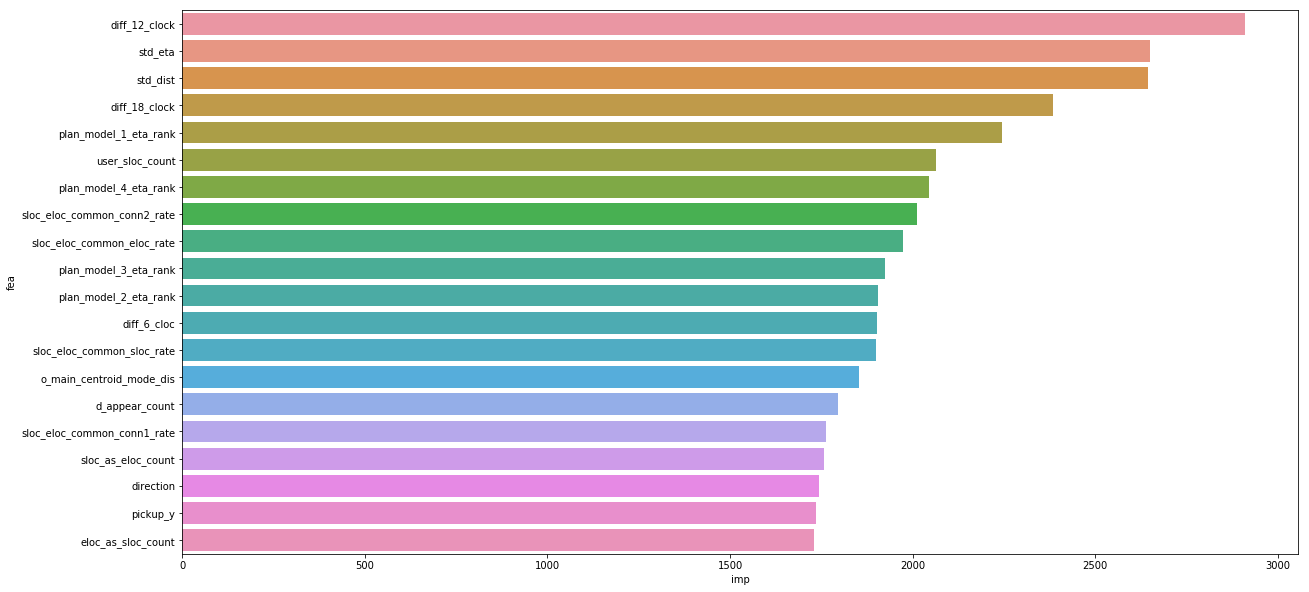

In [17]:
#特征重要性分析
imp = pd.DataFrame()
imp['fea'] = feature
imp['imp'] = lgb_model.feature_importances_ 
imp = imp.sort_values('imp',ascending = False)
imp
plt.figure(figsize=[20,10])
sns.barplot(x = 'imp', y ='fea',data = imp.head(20))

#预测结果分析
proba = lgb_model.predict_proba(valid_x)
pred = pred_proba(proba)
score=f1_score(valid_y, pred, average='weighted')
print('offline_f1_score:', score)
df_analysis = pd.DataFrame()
df_analysis['sid']   = data[valid_index]['sid']
df_analysis['label'] = valid_y.values
df_analysis['pred']  = pred
df_analysis['label'] = df_analysis['label'].astype(int)

score_df = pd.DataFrame(
    columns=['class_id', 'counts*f1_score', 'f1_score', 'precision', 'recall'])



In [11]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score,recall_score,precision_score
dic_ = df_analysis['label'].value_counts(normalize = True)
def get_weighted_fscore(y_pred, y_true):
    f_score = 0
    for i in range(12):
        yt = y_true == i
        yp = y_pred == i
        f_score += dic_[i] * f1_score(y_true=yt, y_pred= yp)
        score_df.loc[i] = i,dic_[i],f1_score(y_true=yt, y_pred= yp), precision_score(y_true=yt, y_pred= yp),recall_score(y_true=yt, y_pred= yp)
    print('f_score:', f_score)
    return score_df
score_df = get_weighted_fscore(y_true =df_analysis['label'] , y_pred = df_analysis['pred'])
print(score_df)

#模型训练&提交
all_train_x              = data[data.req_time < '2018-12-01'][feature].reset_index(drop=True)
all_train_y              = data[data.req_time < '2018-12-01'].click_mode.reset_index(drop=True)
print(lgb_model.best_iteration_)
lgb_model.n_estimators   = lgb_model.best_iteration_
lgb_model.fit(all_train_x, all_train_y)
print('fit over')
result                   = pd.DataFrame()
result['sid']            = data[test_index]['sid']
result.reset_index(inplace=True)
result.drop(['index'],axis=1,inplace=True)
result_proba = lgb_model.predict_proba(test_x)
a  = pd.DataFrame(pred_proba(result_proba))
result= pd.concat([result,a],axis=1)
result=result.rename(columns={0:'recommend_mode'})
print(len(result))
print(result['recommend_mode'].value_counts())
filename="shenzhen_{:%Y-%m-%d_%H_%M}_sub.csv".format(datetime.now())
result[['sid', 'recommend_mode']].to_csv(filename, index=False)

f_score: 0.03468026386606644
    class_id  counts*f1_score  f1_score  precision    recall
0        0.0         0.116318  0.006840   0.100775  0.003540
1        1.0         0.143244  0.032606   0.133228  0.018576
2        2.0         0.253845  0.062015   0.264319  0.035128
3        3.0         0.032342  0.001910   0.038462  0.000979
4        4.0         0.018024  0.000000   0.000000  0.000000
5        5.0         0.109888  0.030633   0.125780  0.017440
6        6.0         0.016900  0.004835   0.017241  0.002812
7        7.0         0.155947  0.040689   0.162411  0.023258
8        8.0         0.003089  0.000000   0.000000  0.000000
9        9.0         0.112185  0.029797   0.100000  0.017507
10      10.0         0.019893  0.007003   0.029070  0.003981
11      11.0         0.018325  0.007358   0.024752  0.004322
5
fit over


KeyboardInterrupt: 

# 专门调阈值顺序，验证下猜想

In [18]:
proba = lgb_model.predict_proba(valid_x)
the_before_score=0

In [191]:
#proba = lgb_model.predict_proba(valid_x)
def pred_proba(proba):
    res = []
#    pred_proba.tolist()
    for i, row in enumerate(proba):
        row1=list(row)
        
        

        if row[0] >= 0.3892:
            row1[0] = 1
        if row1[1] >= 0.4562:
            row1[1] = 1
        if row1[2] >= 0.4872:
            row1[2] = 1
        if row[3] >= 0.2043:
            row1[3] = 1
        if row[4] >= 0.1544:
            row1[4] = 1  
        if row[5] > 0.3196:
            row1[5] = 1
        if row[6] > 0.1325:
            row1[6] = 1
        if row[7] > 0.30940:
            row1[7] = 1     
        if row[8] > 0.1585:
            row1[8] = 1
        if row[9] >  0.2933:
            row1[9] = 1  
        if row[10] > 0.2133:
            row1[10] = 1
            
        if row[11] > 0.2993:
            row1[11] = 1
        res.append(row1)
        

    df = pd.DataFrame(res)
    #print('duide:',df)
    
#     bushi_1_count=0                                     #1206个  不止1个判断结果的。
#     for index,row in df.iterrows():
#         if 1.0 in list(row):
#             bushi_count=list(row).count(1)
#             if bushi_count>1:
#                 bushi_1_count=bushi_1_count+1
            
#     print(bushi_1_count)
    pred=[]
    for ind,row in df.iterrows():
        row=list(row)
        if 1.0 in list(row):

            if row[10]==1:
                pred.append(10)
            elif row[4]==1:
                pred.append(4)
            elif row[3]==1:
                pred.append(3)
            elif row[6]==1:
                pred.append(6)
            elif row[0]==1:
                pred.append(0)
            elif row[1]==1:
                pred.append(1)
            elif row[11]==1:
                pred.append(11)

            else:
                pred.append(list(row).index(max(row)))
        else:
            pred.append(row.index(max(row)))
                
    #pred = df.idxmax(axis = 1)
    return pred

In [192]:
#预测结果分析
import gc
gc.collect()

the_before_score=proba
#print('beefore_f1_score:', score)
print(proba.shape)
pred = pred_proba(proba)
print(len(pred))
score=f1_score(valid_y, pred, average='weighted')
print('offline_f1_score:', score)
df_analysis = pd.DataFrame()
df_analysis['sid']   = data[valid_index]['sid']
df_analysis['label'] = valid_y.values
df_analysis['pred']  = pred
df_analysis['label'] = df_analysis['label'].astype(int)

score_df = pd.DataFrame(
    columns=['class_id', 'counts*f1_score', 'f1_score', 'precision', 'recall'])

from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score,recall_score,precision_score
dic_ = df_analysis['label'].value_counts(normalize = True)
def get_weighted_fscore(y_pred, y_true):
    f_score = 0
    for i in range(12):
        yt = y_true == i
        yp = y_pred == i
        f_score += dic_[i] * f1_score(y_true=yt, y_pred= yp)
        score_df.loc[i] = i,dic_[i],f1_score(y_true=yt, y_pred= yp), precision_score(y_true=yt, y_pred= yp),recall_score(y_true=yt, y_pred= yp)
    print('f_score:', f_score)
    return score_df
score_df = get_weighted_fscore(y_true =df_analysis['label'] , y_pred = df_analysis['pred'])
print(score_df)

(63137, 12)
1206
63137
offline_f1_score: 0.7191737211450785
f_score: 0.7191737211450785
    class_id  counts*f1_score  f1_score  precision    recall
0        0.0         0.116318  0.386589   0.885422  0.247277
1        1.0         0.143244  0.720221   0.692339  0.750442
2        2.0         0.253845  0.898296   0.873813  0.924190
3        3.0         0.032342  0.116719   0.299595  0.072478
4        4.0         0.018024  0.074453   0.219828  0.044815
5        5.0         0.109888  0.850975   0.799873  0.909052
6        6.0         0.016900  0.308037   0.256219  0.386129
7        7.0         0.155947  0.793914   0.752593  0.840037
8        8.0         0.003089  0.348285   0.358696  0.338462
9        9.0         0.112185  0.802741   0.698901  0.942821
10      10.0         0.019893  0.554017   0.490196  0.636943
11      11.0         0.018325  0.721210   0.598744  0.906655
